In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import seaborn as sns

### Подготовка данных для использования
 - Получение Датасета
 - Получение Даталоадера
 - Просмотр данных

In [2]:
train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform=ToTensor()
)
test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform=ToTensor()
)

In [3]:
BATCH_SIZE = 64

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [5]:
### Целевое значение
next(iter(train_dataloader))[1]

tensor([2, 8, 5, 3, 1, 9, 2, 8, 4, 9, 0, 1, 6, 2, 7, 9, 5, 8, 1, 9, 4, 0, 8, 6,
        1, 6, 6, 0, 8, 9, 6, 5, 3, 7, 9, 7, 7, 9, 9, 5, 1, 5, 7, 6, 2, 9, 5, 5,
        9, 1, 8, 7, 6, 1, 5, 6, 3, 0, 4, 5, 3, 7, 4, 2])

In [6]:
### Torch tensor
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

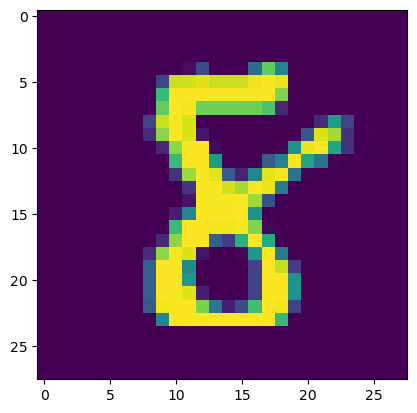

In [7]:
for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

### Построим нейронную сеть, чтобы для решения задачи бинарной классфикации (является ли цифра 9-кой или нет)

In [8]:
class IsOne(torch.nn.Module):
    def __init__(self, dims=[256, 64, 32], dropout_p=0.3): #добавление массива количества нейронов и вероятности dropout
        super().__init__()
        self.Linear1 = torch.nn.Linear(28 * 28, dims[0])
        self.Linear2 = torch.nn.Linear(dims[0], dims[1])
        self.Linear3 = torch.nn.Linear(dims[1], dims[2]) #добавление одного внутреннего слоя
        self.Linear4 = torch.nn.Linear(dims[2], 10) #размерность выхода 10
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_p)# добавлен слой с dropout
        self.SoftMax = torch.nn.Softmax(dim=1) #изменена функция активации на выходе
        
        
    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.dropout(x)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x)
        x = self.relu(x)
        x = self.Linear4(x)
        x = self.SoftMax(x)
        return x

In [9]:
model = IsOne()

### Функция, вычисляющая лосс

In [10]:
def loss_function(true, pred): 
    loss = torch.nn.CrossEntropyLoss() #изменена функция потерь
    return loss(pred, true)

### Оптимизатор

In [11]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)

### Построим процесс обучения нейронной сети

In [12]:
NUM_EPOCHS = 250

In [13]:
train_loss = []
test_loss = []
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train(True)
    train_loss_epoch = 0
    test_loss_epoch = 0
    for X, y in train_dataloader:
        model.zero_grad()
        true = y
        predictions = model.forward(X)
        loss_value = loss_function(true, predictions)
        loss_value.backward()
        train_loss_epoch += loss_value.item()/len(train_dataloader)
        optimizer.step()
    train_loss.append(train_loss_epoch)
    model.train(False)
    for X, y in test_dataloader:
        true = y
        predictions = model.forward(X)
        loss_value = loss_function(true, predictions)
        test_loss_epoch += loss_value.item()/len(test_dataloader)
    test_loss.append(test_loss_epoch)
    # print(epoch, train_loss[-1], test_loss[-1])

100%|██████████| 250/250 [37:15<00:00,  8.94s/it]


<Axes: >

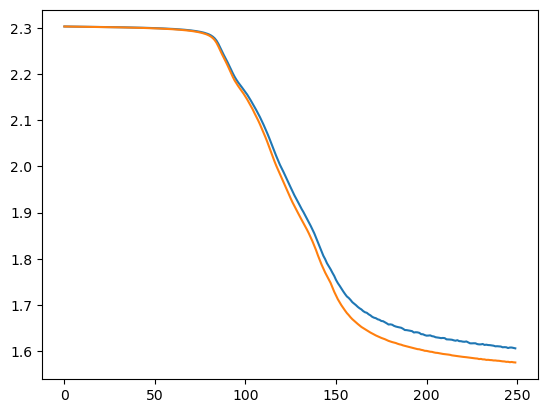

In [14]:
sns.lineplot(train_loss)
sns.lineplot(test_loss)

In [15]:
preds = []
reals = []
for X, y in test_dataloader:
    preds.append(model(X).detach().numpy())
    reals.append(y.numpy())

In [16]:
preds = (np.concatenate(preds).argmax(axis=1)).astype(int)

In [17]:
reals = np.concatenate(reals)

In [18]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [19]:
print(classification_report(reals, preds))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       977
           1       0.95      0.97      0.96      1134
           2       0.91      0.89      0.90      1030
           3       0.91      0.88      0.89      1009
           4       0.88      0.92      0.90       980
           5       0.84      0.75      0.80       891
           6       0.90      0.94      0.92       957
           7       0.94      0.86      0.90      1027
           8       0.84      0.86      0.85       970
           9       0.85      0.89      0.87      1009

    accuracy                           0.89      9984
   macro avg       0.89      0.89      0.89      9984
weighted avg       0.89      0.89      0.89      9984



### Домашняя работа
Изменить нейронную сеть следующим образом:
 - Чтобы она решала задачу не бинарной классификации, а многоклассовой (Для этого нужно использовать другую лосс функцию и функцию активации на выходе)
 - Чтобы в ней было не 2 скрытых слоя, а три
 - Чтобы кол-во нейронов подставлялось через массив, поданный при инициализации класса модели
 - Чтобы происходил dropout (вероятность 0.3) до первого скрытого слоя. Показать, как это изменение повлияло на результат работы модели на тестовой выборке.
 - Посчитать метрики классификации через classification report (sklearn) для каждого класса